# Calculate phase dependent modulation of AP threshold poisson excitation and rhythmic inhibition

The simulations had either: 
1. Rhythmic inhibition at the soma (64 Hz) or dendrites (16 Hz) 
2. Poisson excitation at the soma and dendrites

Here we calculate voltage threshold for action potentials. These are stratified by:
1. Phase (peak or trough) of the inhibitory rhythm
2. Frequency of rhythm

The output of this script are...


In [1]:
import sys
sys.path.append('..') # have to do this for relative imports in jupyter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.load_spike_h5 import load_spike_h5
from src.load_v_h5 import load_v_h5

## 1.0 Analysis parameters


### 1.1 Simulation constants and analysis windows

In [8]:
samps_per_ms = 10 
edges_v = np.arange(-80,-40,1)

sim_win = [0, 2000000] # beginning and start points of simulation in samples

### 1.2 List files to be processed

In [7]:
# locate simulation files
root_16_dir = 'Y:\\DendCompOsc\\output_16Hz_no_exc_mod\\'
sim_16_dict = {'SimName': 'output_16Hz_no_exc_mod',
               'RootDir': root_16_dir,
               'CaFile': root_16_dir + 'output_16Hz_no_exc_mod_ca.csv',
               'NaFile': root_16_dir + 'output_16Hz_no_exc_mod_na.csv',
               'NMDAFile': root_16_dir + 'output_16Hz_no_exc_mod_nmda.csv',
               'APFile': root_16_dir + 'spikes.h5',
               'VMemFile': root_16_dir + 'v_report.h5'}

root_64_dir = 'Y:\\DendCompOsc\\output_64Hz_no_exc_mod\\'
sim_64_dict = {'SimName': 'output_64Hz_no_exc_mod',
               'RootDir': root_64_dir,
               'CaFile': root_64_dir + 'output_64Hz_no_exc_mod_ca.csv',
               'NaFile': root_64_dir + 'output_64Hz_no_exc_mod_na.csv',
               'NMDAFile': root_64_dir + 'output_64Hz_no_exc_mod_nmda.csv',
               'APFile': root_64_dir + 'spikes.h5',
               'VMemFile': root_64_dir + 'v_report.h5'}


## 2.0 Phase binned histograms for dendritic and somatic spikes

### 2.1 Generate phase series for each experiment

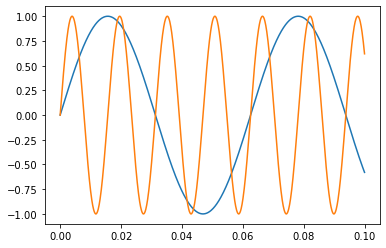

In [6]:
# generate phase time series for inhibitory afferents
t_ser = np.arange(sim_win[0], sim_win[1], 1) / 10000 # seconds
sin_16_ser = np.sin(t_ser*16*2*np.pi)
sin_64_ser = np.sin(t_ser*64*2*np.pi)

fig, ax = plt.subplots()
ax.plot(t_ser[0:1000],sin_16_ser[0:1000])
ax.plot(t_ser[0:1000],sin_64_ser[0:1000])
plt.show()

### 2.2 Calculate action potential threshold voltage

In [60]:
# probability of action potentials by membrane voltage
def ap_prob_func(spk, v, edges):
    null_hist = np.histogram(v, edges)
    spk_hist = np.histogram(v[spk-10], edges)
    spk_cum_prob = np.cumsum(spk_hist[0]/null_hist[0])
    return {'null': null_hist[0], 'spk': spk_hist[0], 'prob': spk_cum_prob}


def thresh_files_func(sim_dict, sin_ser):
    spk_prob = {}


    # split action potentials based on phase of rhythm
    spk_t = load_spike_h5(sim_dict['APFile'])
    spk_t_p = np.intersect1d(spk_t, np.where(sin_ser >= 0))
    spk_t_t = np.intersect1d(spk_t, np.where(sin_ser < 0))
    
    # load soma voltage
    mem_v = load_v_h5(sim_dict['VMFile'], 0)

    # calculate action potential probability for each phase
    spk_prob['p'] = ap_prob_func(spk_t_p, mem_v, edges_v)
    spk_prob['t'] = ap_prob_func(spk_t_t, mem_v, edges_v)

    return spk_prob



In [61]:
# process the 16 Hz distal dendritic inhibition simulation
ph_16_bin = bin_files_func(sim_16_dict, ph_16_ser, sin_16_ser)

# process the 64 Hz proximal dendritic/somatic inhibition simulation
ph_64_bin = bin_files_func(sim_64_dict, ph_64_ser, sin_64_ser)

c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\InhibOnDendComp\scripts\..\src\bin_serser.py:50: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\ds\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\InhibOnDendComp\scripts\..\src\bin_rhythmic_files.py:47: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  dend_t = load_dendevt_csv(dend_fname)


### 2.3 Plots

In [97]:
# plotting functions
def stairs_plot(sig_ser, sin_ser, ax):
        sc_func = lambda x: ((x+1)/2)*np.max(sig_ser[1:])

        ax.stairs(np.hstack((sig_ser[1:],sig_ser[1:])),
                        np.hstack((edges[:-1], edges+2*np.pi)), 
                        baseline=0, fill=True)
        ax.plot(np.hstack((edges, edges+2*np.pi)), 
                np.hstack((sc_func(sin_ser), sc_func(sin_ser))),color='k')
        ax.plot(np.linspace(-np.pi,3*np.pi,100),
                sc_func(np.sin(np.linspace(-np.pi,3*np.pi,100))), 
                color='r', linestyle=':')
        ax.set_xticks(np.pi/2*np.arange(-2,7))
        ax.tick_params(axis='x', rotation=90)

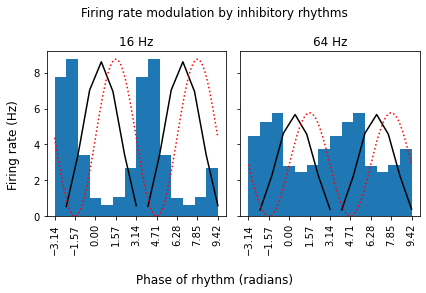

In [115]:
# Action potentials
fig, ax = plt.subplots(1,2,sharey=True)
stairs_plot(ph_16_bin['ap'], ph_16_bin['sin'], ax[0])
stairs_plot(ph_64_bin['ap'], ph_64_bin['sin'], ax[1])
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
fig.suptitle('Firing rate modulation by inhibitory rhythms')
fig.supxlabel('Phase of rhythm (radians)')
fig.supylabel('Firing rate (Hz)')
plt.tight_layout()
plt.show()


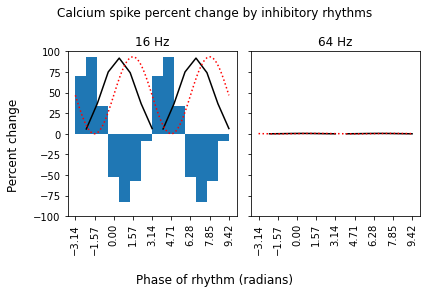

In [116]:
# calcium spikes
fig, ax = plt.subplots(1,2,sharey=True)
stairs_plot(ph_16_bin['ca_a'][0], ph_16_bin['sin'], ax[0])
stairs_plot(ph_64_bin['ca_a'][0], ph_64_bin['sin'], ax[1])
ax[0].set_ylim([-100,100])
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
fig.suptitle('Calcium spike percent change by inhibitory rhythms')
fig.supxlabel('Phase of rhythm (radians)')
fig.supylabel('Percent change')
plt.tight_layout()
plt.show()

#### Plot percent change in dendritic event occurrence with repect to APs

In [112]:
# plot phase-dependent modulation of dendritic events stratified by electrotonic distance
eqt_list = np.arange(9,0,-1)
eqt_inds = np.where(eqt_list>0)[0]
def plot_sta_im(data_arr,vlim, ax):
    ax_im = ax.imshow(np.hstack((data_arr[eqt_inds[0]:eqt_inds[-1],1:], 
                                 data_arr[eqt_inds[0]:eqt_inds[-1],1:])),
                      extent=[-np.pi, 3*np.pi, eqt_list[eqt_inds[0]], eqt_list[eqt_inds[-1]]],
                      vmin=vlim[0], vmax=vlim[1],
                      interpolation='none',
                      cmap='coolwarm')
    
    plt.colorbar(ax_im,ax=ax)
    ax.set_aspect('auto')

# array plots
def plot_dend_set(ph_bin_data, vlim, fig, ax):
    plot_sta_im(ph_bin_data['nmda_a'], vlim, ax[0,0])
    ax[0,0].set_title('NMDA Apical')
    ax[0,0].set_xticks(np.pi/2*np.arange(-2,7))
    ax[0,0].tick_params(axis='x', rotation=90)
    plot_sta_im(ph_bin_data['nmda_b'], vlim, ax[1,0])
    ax[1,0].set_title('NMDA Basal')
    ax[1,0].set_xticks(np.pi/2*np.arange(-2,7))
    ax[1,0].tick_params(axis='x', rotation=90)
    plot_sta_im(ph_bin_data['na_a'], vlim, ax[0,1])
    ax[0,1].set_title('Na Apical')
    ax[0,1].set_xticks(np.pi/2*np.arange(-2,7))
    ax[0,1].tick_params(axis='x', rotation=90)
    plot_sta_im(ph_bin_data['na_b'], vlim, ax[1,1])
    ax[1,1].set_title('Na Basal')
    ax[1,1].set_xticks(np.pi/2*np.arange(-2,7))
    ax[1,1].tick_params(axis='x', rotation=90)
    fig.supxlabel('Phase of rhythm (radians)')
    fig.supylabel('Electrotonic quantile 90->0')
    

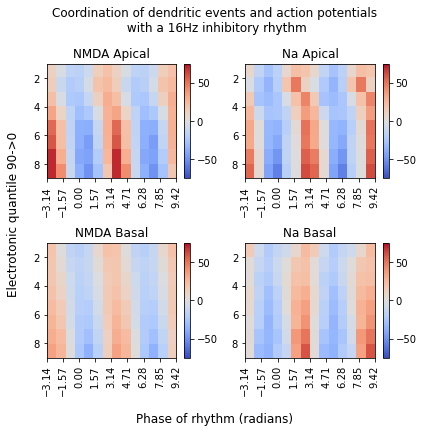

In [113]:
# plot of NMDA and Na spikes for 16 hz dend inhib
fig,ax = plt.subplots(2,2)
plot_dend_set(ph_16_bin, [-75, 75], fig, ax)
fig.suptitle('Coordination of dendritic events and action potentials\n'
             + ' with a 16Hz inhibitory rhythm')
fig.set_size_inches(6,6)
fig.tight_layout()


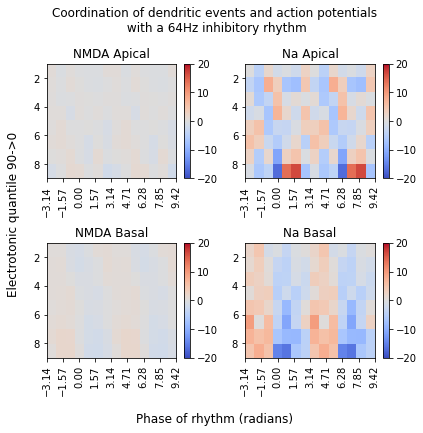

In [114]:
# plot of NMDA and Na spikes for 64 hz somatic inhib
fig,ax = plt.subplots(2,2)
plot_dend_set(ph_64_bin, [-20, 20], fig, ax)
fig.suptitle('Coordination of dendritic events and action potentials\n'
             + ' with a 64Hz inhibitory rhythm')
fig.set_size_inches(6,6)
fig.tight_layout()

## 3.0 Phase-dependent modulation of AP/dendritic spike coupling

### 3.1 Calculate phase-dependent cross-correlations

In [20]:
# trying out cc
nmda_file = sim_64_dict['NMDAFile']
ap_file = sim_64_dict['APFile']

ph_mask = sin_64_ser >= 0

# process action potential events
spk_t = load_spike_h5(ap_file)
spk_ser = ser_pt(spk_t, step, sim_win).to_numpy()

# create spike series and keep only those with the right phase
spk_ser_t = spk_ser.copy().astype(float)
spk_ser_p = spk_ser.copy().astype(float)
spk_ser_t[np.where(ph_mask)[0]] = 0
spk_ser_p[np.where(~ph_mask)[0]] = 0

# turn dendritic events into series
dend_t = load_dendevt_csv(nmda_file)
dend_seg = seg_dendevt(dend_t)
dend_seg = ser_seg_dendevt(dend_seg, step_len=step, win_lim=sim_win)
dend_seg = mean_dendevt(dend_seg)

C:\Users\dbh60\AppData\Local\Temp/ipykernel_3160/2566166146.py:18: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  dend_t = load_dendevt_csv(nmda_file)


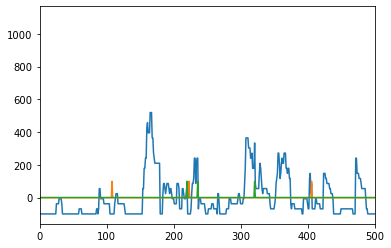

In [63]:
nmda_sig = dend_seg['evt_mean'].loc[(7, 'dend')]
fig, ax = plt.subplots()
ax.plot(nmda_sig)
ax.plot(spk_ser_t*100)
ax.plot(spk_ser_p*100)
ax.set_xlim([0,500])
plt.show()

c:\Users\dbh60\.conda\envs\ds\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\dbh60\.conda\envs\ds\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


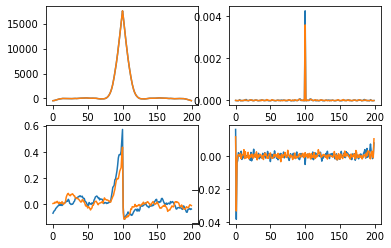

In [65]:
cc_t = cc_serser(nmda_sig,spk_ser_t,[-100,100])
ac_nmda_t = cc_serser(nmda_sig,nmda_sig,[-100,100])
ac_spk_t = cc_serser(spk_ser_t,spk_ser_t,[-100,100])
cc_corr_t = np.fft.ifft(np.square(np.fft.fft(cc_t['values']))/(np.fft.fft(ac_nmda_t['values'])*np.fft.fft(ac_spk_t['values'])))
cc_p = cc_serser(nmda_sig,spk_ser_p,[-100,100])
ac_nmda_p = cc_serser(nmda_sig,nmda_sig,[-100,100])
ac_spk_p = cc_serser(spk_ser_p,spk_ser_p,[-100,100])
cc_corr_p = np.fft.ifft((np.fft.fft(cc_p['values'])**2)/(np.fft.fft(ac_nmda_p['values'])*np.fft.fft(ac_spk_p['values'])))
fig,ax=plt.subplots(2,2)
ax[0,0].plot(ac_nmda_t['values'])
ax[0,0].plot(ac_nmda_p['values'])
ax[0,1].plot(ac_spk_t['values'])
ax[0,1].plot(ac_spk_p['values'])
ax[1,0].plot(cc_t['values'])
ax[1,0].plot(cc_p['values'])
ax[1,1].plot(cc_corr_t)
ax[1,1].plot(cc_corr_p)
plt.show()

In [6]:
# Corrected cross covariance stratified by inhibitory phase
# in this function, trough refers to the lull in inhibitory afferents, while peak
# is the maximum of inhibitory afferents
def cc_corr_func(sim_dict, sin_ser):
    ph_cc = {}

    ph_cc['ca_cc'] = cc_phdep_files(sim_dict['CaFile'], sim_dict['APFile'], sin_ser, step, sim_win, sta_win)
    ph_cc['nmda_cc'] = cc_phdep_files(sim_dict['NMDAFile'], sim_dict['APFile'], sin_ser, step, sim_win, sta_win)
    ph_cc['na_cc'] = cc_phdep_files(sim_dict['NaFile'], sim_dict['APFile'], sin_ser, step, sim_win, sta_win)
    
    # trough of inhibitory drive
    ph_cc['ca_a_t'] = ph_cc['ca_cc'].loc['apic','cc_t']
    ph_cc['nmda_a_t'] = ph_cc['nmda_cc'].loc['apic','cc_t']
    ph_cc['nmda_b_t'] = ph_cc['nmda_cc'].loc['dend','cc_t']
    ph_cc['na_a_t'] = ph_cc['na_cc'].loc['apic','cc_t']
    ph_cc['na_b_t'] = ph_cc['na_cc'].loc['dend','cc_t']
    
    # peak of inhibitory drive
    ph_cc['ca_a_p'] = ph_cc['ca_cc'].loc['apic','cc_p']
    ph_cc['nmda_a_p'] = ph_cc['nmda_cc'].loc['apic','cc_p']
    ph_cc['nmda_b_p'] = ph_cc['nmda_cc'].loc['dend','cc_p']
    ph_cc['na_a_p'] = ph_cc['na_cc'].loc['apic','cc_p']
    ph_cc['na_b_p'] = ph_cc['na_cc'].loc['dend','cc_p']

    return ph_cc

In [7]:
# process the 16 Hz distal dendritic inhibition simulation
ph_16_cc = cc_corr_func(sim_16_dict, sin_16_ser)

# process the 64 Hz proximal dendritic/somatic inhibition simulation
ph_64_cc = cc_corr_func(sim_64_dict, sin_64_ser)

c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\InhibOnDendComp\scripts\..\src\cc_phdep_files.py:69: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  dend_t = load_dendevt_csv(dend_fname)


In [7]:
print(ph_16_cc['nmda_cc'])

                                                   cc_t
Type                                                   
apic  [[0.07893895362914576, 0.06398187384960959, 0....
dend  [[0.036317121869727534, 0.0309789355473718, 0....


In [77]:
"""def plot_ph_cc(cc_dict, fig, ax):
    
    ax[0,0].imshow(cc_dict['nmda_b_p'][1:,:])
    ax[1,0].imshow(cc_dict['nmda_b_t'][1:,:])
    ax[2,0].imshow(cc_dict['nmda_b_t'][1:,:]-cc_dict['nmda_b_p'][1:,:])
    ax[0,0].set_aspect('auto')
    ax[1,0].set_aspect('auto')
    ax[2,0].set_aspect('auto')"""
    
def plot_ph_cc(cc_dict, fig, ax):
    
    ax[0].plot(cc_dict['nmda_a_p'][7,:])
    ax[0].plot(cc_dict['nmda_a_t'][7,:])
    ax[1].plot(cc_dict['nmda_a_t'][7,:]-cc_dict['nmda_a_p'][7,:])

def plot_ph_peak(cc_dict, fig, ax):
    ax[0].plot(cc_dict['ca_a_p'][:,99]/cc_dict['ca_a_p'][8,99])
    ax[0].plot(cc_dict['ca_a_t'][:,99]/cc_dict['ca_a_t'][8,99])
    ax[1].plot(cc_dict['nmda_b_t'][:,99]-cc_dict['nmda_b_p'][:,99])
    


<function matplotlib.pyplot.show(close=None, block=None)>

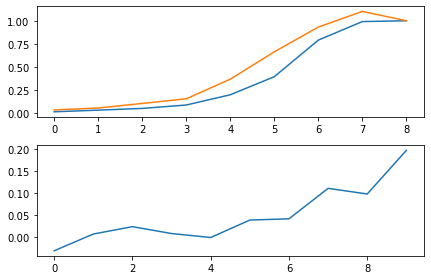

In [78]:
fig, ax = plt.subplots(2,1)
plot_ph_peak(ph_64_cc, fig, ax)
fig.tight_layout()
plt.show